# General utilities

In [1]:
import os
import math
import json
import numpy as np
import pandas as pd
from ast import literal_eval
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import torch.nn.functional as F

from utils import *
from vis import revision2tokens_pythia, revision2tokens_bloom, revision2tokens_olmo

def prepare_pythia_revision_list():
    init_steps = [int(mystr) for mystr in  "0 1 2 4 8 16 32 64 128 256 512 1000 2000 4000 8000 10000 16000".split(" ")]
    final_steps = list(range(20000, 143000, 10000))
    revision_list = init_steps + final_steps + ["143000"]
    revision_list = ["step" + str(step) for step in revision_list]
    print(len(revision_list))
    return revision_list

def prepare_olmo_revision_list():
    init_steps = [int(mystr) for mystr in ["0", "1000", "2000", "4000", "8000", "10000", "16000"]]
    middle_steps = list(range(20_000, 143_000, 10000))
    final_steps = list(range(143_000, 1_454_000, 100_000))
    revision_list = init_steps + middle_steps +final_steps + [1454000]
    revision_list = ["step" + str(step) for step in revision_list]

    with open("scripts/checkpoint_lists/checkpoints_allenai_OLMo-1B-0724-hf.txt") as fp:
        lines = fp.readlines()
        lines = [line.strip() for line in lines]
        
    step2rev = {}
    for line in lines:
        step = line.split("-")[0]
        step2rev[step] = line
        
    revision_list = [step2rev[step] for step in revision_list]
    print(len(revision_list))
    return revision_list

def prepare_bloom_revision_list():
    steps = [1_000, 10_000, 100_000, 200_000, 300_000, 500_000, 600_000]
    revision_list = ["global_step" + str(step) for step in steps]
    print(len(revision_list))
    return revision_list

def format_tokens(n):
    if n >= 1e9:
        return f"{n/1e9:.0f}B"
    elif n >= 1e6:
        return f"{n/1e6:.0f}M"
    else:
        return str(n)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Accuracy Plots

### Pythia & OLMo on BLiMP SV-Agreement

In [2]:
dir_list = ["workspace/results/lm_eval_harness_res/EleutherAI__pythia-1b", "workspace/results/lm_eval_harness_res/allenai__OLMo-1B-0724-hf"]
latest_records = {}

for input_dir in dir_list:
    for filename in os.listdir(input_dir):
        if not filename.endswith(".json"):
            continue

        file_path = os.path.join(input_dir, filename)
        with open(file_path, "r") as f:
            data = json.load(f)

        result = data.get("results", {})
        if "blimp" not in result.keys():
            continue
        
        config = data.get("config", {})
        model_args = config.get("model_args", "")
        date = data.get("date")

        model_name = None
        revision = None
        tokens = None
        if "pretrained=" in model_args:
            parts = model_args.split(",")
            for part in parts:
                if part.startswith("pretrained="):
                    model_name = part.split("=")[-1]
                if part.startswith("revision="):
                    revision = part.split("revision=")[1]
                    if model_name == "EleutherAI/pythia-1b":
                        tokens = int(revision.split("step")[-1])
                        tokens = int(tokens * 2e6)
                    elif model_name == "allenai/OLMo-1B-0724-hf":
                        if "main" in part:
                            continue
                        tokens = revision.split("tokens")[1]
                        tokens = int(int(tokens.split("B")[0]) * 1e9)
                    
        if revision == "main":
            continue
        
        key = (model_name, revision)
        
        if filename == "results_2025-06-16T07-58-24.455603.json":
            print("Found the particular result!")
        
        if key in latest_records:
            if latest_records[key]["date"] >= date:
                continue
        
        record = {
            "model": model_name,
            "tokens": tokens,
            "revision": revision,
            "date": date
        }
        
        if filename == "results_2025-06-16T07-58-24.455603.json":
            print("Found the particular result!")
            print(record)

        for task, scores in result.items():
            if task.startswith("blimp_") and "acc,none" in scores:
                record[task] = scores["acc,none"]

        latest_records[key] = record

# Sort records by revision & convert to DataFrame and export to CSV
df = pd.DataFrame(latest_records.values()).drop(columns=["date"])
df = df.sort_values(by=["model", "tokens"])
df.to_csv("workspace/results/aggregated_blimp_results.csv", index=False)
print("Saved aggregated_blimp_results.csv")


Found the particular result!
Found the particular result!
{'model': 'allenai/OLMo-1B-0724-hf', 'tokens': 33000000000, 'revision': 'step16000-tokens33B', 'date': 1750060253.3891191}
Saved aggregated_blimp_results.csv


31
35


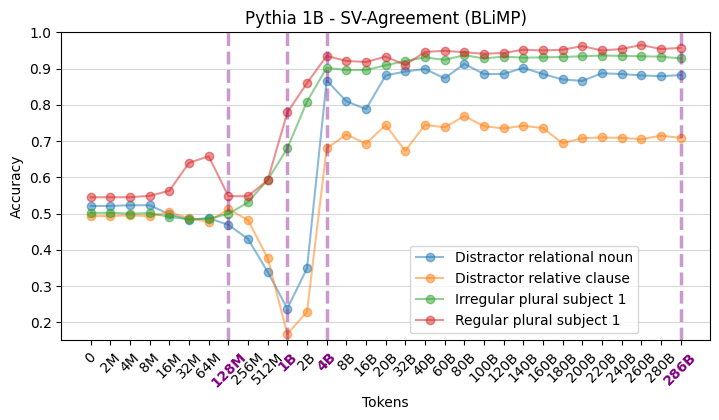

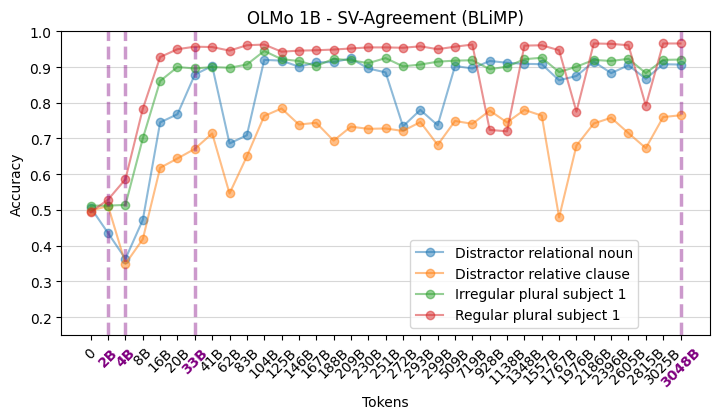

In [3]:
blimp_cols = [col for col in df.columns if col.startswith("blimp_")]
category2task = {}

sel_tasks = [
    "distractor_agreement_relational_noun",
    "distractor_agreement_relative_clause",
    "irregular_plural_subject_verb_agreement_1",
    "irregular_plural_subject_verb_agreement_2",
    "regular_plural_subject_verb_agreement_1",
    "regular_plural_subject_verb_agreement_2"
]

blimp_sel_tasks = ["blimp_" + task for task in sel_tasks]

task2name = {
    "distractor_agreement_relational_noun": "Distractor relational noun",
    "distractor_agreement_relative_clause": "Distractor relative clause",
    "irregular_plural_subject_verb_agreement_1": "Irregular plural subject 1",
    "regular_plural_subject_verb_agreement_1": "Regular plural subject 1" 
}

# Save tasks to a text file, one task per line
task_list_path = "scripts/blimp_task_list.txt"
with open(task_list_path, "w") as f1:
    for task in blimp_cols:
        ftask = task.replace("blimp_", "")
        with open(f"data/blimp_data/{ftask}.jsonl", "r") as f2:
            first_line = f2.readline()
            first_dict = json.loads(first_line)
            category = first_dict["linguistics_term"]
            if category not in category2task:
                category2task[category] = []
            category2task[category].append(task)
        f1.write(f"{ftask},{category}\n")

# Filter for Pythia and OLMo models
df_pythia = df[df['model'].str.contains("pythia", case=False)]
df_olmo = df[df['model'].str.contains("olmo", case=False)]
pythia_valid_rev = prepare_pythia_revision_list()
olmo_valid_rev = prepare_olmo_revision_list()

df_pythia = df_pythia[df_pythia["revision"].isin(pythia_valid_rev)]
df_olmo = df_olmo[df_olmo["revision"].isin(olmo_valid_rev)]

def plot_blimp_cat(df_model, cat, model_name, save_path=None,
                   label_skip=2, figsize=(7,4), highlight_indices=[3, 7, 11, 15]):
    # 1) sort + prepare x coords & tick labels
    df_sorted = df_model.sort_values("tokens")
    tokens = df_sorted["tokens"].tolist()
    labels = [format_tokens(t) for t in tokens]
    x = list(range(len(labels)))
    shown_labels = [lab if i % label_skip == 0 else ""
                    for i, lab in enumerate(labels)]
    
    # 2) create a Figure+Axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # 3) plot each curve
    for task in category2task[cat]:
        if task.endswith("2"):
            continue
        y = df_sorted[task]
        name = (task2name[task.replace("blimp_", "")]
                if cat=="subject_verb_agreement"
                else task.replace("blimp_", ""))
        ax.plot(x, y, label=name,
                marker="o", alpha=0.5)
    
    # 4) labels, grid, legend
    ax.set_title(f"{model_name} - "
                 f"{'SV-Agreement (BLiMP)' if cat=='subject_verb_agreement' else cat}")
    ax.set_xlabel("Tokens")
    ax.set_ylabel("Accuracy")
    ax.set_xticks(x)
    ax.set_xticklabels(shown_labels, rotation=45)
    ax.grid(True, axis='y', alpha=0.5) #0.5)
    ax.set_ylim(0.15, 1.0)
    
    # 2) color choice
    hl_color = "purple"  # or any named color, hex code, etc.

    # 3) draw vertical lines
    for xi in highlight_indices:
        ax.axvline(x=xi, color=hl_color, linestyle="--", linewidth=2.5, alpha=0.4)

    # 4) recolor the matching tick‐labels
    for i, lbl in enumerate(ax.get_xticklabels()):
        if i in highlight_indices:
            lbl.set_color(hl_color)
            lbl.set_fontweight("bold")   # optional, to make it pop

    # 5) legend/grid/tight_layout
    # fig.tight_layout(pad=0)
    
    ax.legend(loc='lower right',
              bbox_to_anchor=(0.9, 0))
    
    # 5) zero‐pad everything
    fig.tight_layout(pad=0)
    
    # 6) save the PDF (or show interactively)
    if save_path:
        fig.savefig(save_path,
                    format="pdf",
                    bbox_inches="tight",
                    pad_inches=0)
    
    plt.show()
    plt.close(fig)

plot_blimp_cat(df_pythia, "subject_verb_agreement", "Pythia 1B", save_path="figs/pythia_blimp_acc.pdf", label_skip=1, highlight_indices=[7, 10, 12, 30])
plot_blimp_cat(df_olmo, "subject_verb_agreement", "OLMo 1B", save_path="figs/olmo_blimp_acc.pdf", label_skip=1, highlight_indices=[1, 2, 6, 34])

### BLOOM on CLAMS SV-Agreement

In [4]:
dir_list = ["workspace/results/lm_eval_harness_res/bigscience__bloom-1b1-intermediate"]
clams_subtasks = [
    "en_long_vp_coord",
    "en_obj_rel_across_anim",
    "en_obj_rel_within_anim",
    "en_prep_anim",
    "en_simple_agrmt",
    "en_subj_rel",
    "en_vp_coord",
    "fr_long_vp_coord",
    "fr_obj_rel_across_anim",
    "fr_obj_rel_within_anim",
    "fr_prep_anim",
    "fr_simple_agrmt",
    "fr_subj_rel",
    "fr_vp_coord"
]
latest_records = {}

for input_dir in dir_list:
    for filename in os.listdir(input_dir):
        if not filename.endswith(".json"):
            continue

        file_path = os.path.join(input_dir, filename)
        with open(file_path, "r") as f:
            data = json.load(f)

        result = data.get("results", {})
        config = data.get("config", {})
        model_args = config.get("model_args", "")
        start_time = data.get("start_time")

        model_name = None
        revision = None
        tokens = None
        if "pretrained=" in model_args:
            parts = model_args.split(",")
            for part in parts:
                if part.startswith("pretrained="):
                    model_name = part.split("=")[-1]
                if part.startswith("revision="):
                    revision = part.split("revision=")[1]
                    if model_name == "bigscience/bloom-1b1-intermediate":
                        if "main" in part:
                            tokens = 341000000000
                        else:
                            print(revision)
                            tokens = int(revision.split("step")[-1])
                            tokens = int(tokens * 550e3)
        
        key = (model_name, revision)
        
        if key in latest_records:
            if latest_records[key]["start_time"] >= start_time:
                continue
        
        record = {
            "model": model_name,
            "tokens": tokens,
            "revision": revision,
            "start_time": start_time
        }
        
        print(record)

        for task, scores in result.items():
            if (task in clams_subtasks) and ("acc,none" in scores):
                record[task] = scores["acc,none"]

        latest_records[key] = record

# Sort records by revision & convert to DataFrame and export to CSV
df_bloom = pd.DataFrame(latest_records.values()).drop(columns=["start_time"])
df_bloom = df_bloom.sort_values(by=["model", "tokens"])
df_bloom.to_csv("workspace/results/aggregated_clams_results.csv", index=False)
print("Saved aggregated_clams_results.csv")


global_step1000
{'model': 'bigscience/bloom-1b1-intermediate', 'tokens': 550000000, 'revision': 'global_step1000', 'start_time': 6016361.750280348}
global_step1000
{'model': 'bigscience/bloom-1b1-intermediate', 'tokens': 550000000, 'revision': 'global_step1000', 'start_time': 6017302.851065369}
global_step10000
{'model': 'bigscience/bloom-1b1-intermediate', 'tokens': 5500000000, 'revision': 'global_step10000', 'start_time': 1795716.294408039}
global_step100000
{'model': 'bigscience/bloom-1b1-intermediate', 'tokens': 55000000000, 'revision': 'global_step100000', 'start_time': 1795717.4765817}
global_step1000
global_step300000
{'model': 'bigscience/bloom-1b1-intermediate', 'tokens': 165000000000, 'revision': 'global_step300000', 'start_time': 567261.677397747}
global_step400000
{'model': 'bigscience/bloom-1b1-intermediate', 'tokens': 220000000000, 'revision': 'global_step400000', 'start_time': 567261.677144123}
{'model': 'bigscience/bloom-1b1-intermediate', 'tokens': 341000000000, 'revis

['en_long_vp_coord', 'en_obj_rel_across_anim', 'en_obj_rel_within_anim', 'en_prep_anim', 'en_simple_agrmt', 'en_subj_rel', 'en_vp_coord', 'fr_long_vp_coord', 'fr_obj_rel_across_anim', 'fr_obj_rel_within_anim', 'fr_prep_anim', 'fr_simple_agrmt', 'fr_subj_rel', 'fr_vp_coord']
Number of Tasks:  14


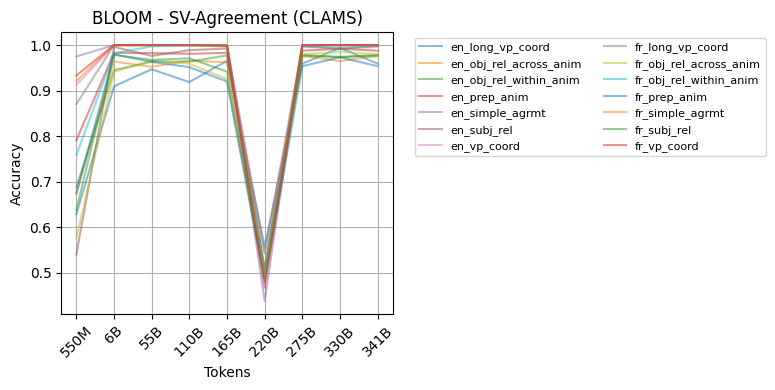

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

clams_tasks = df_bloom.columns.tolist()
clams_tasks.remove("model")
clams_tasks.remove("tokens")
clams_tasks.remove("revision")
print(clams_tasks)
print("Number of Tasks: ", len(clams_tasks))

def plot_model_performance(df_model, model_name, label_skip=5):
    df_sorted = df_model.sort_values("tokens")
    x = df_sorted["tokens"]
    labels = [format_tokens(val) for val in x]
    x = list(range(len(labels)))
    shown_labels = labels

    plt.figure(figsize=(8,4))
    for col in clams_tasks:
        y = df_model[col]
        plt.plot(x, y, label=col, alpha=0.5)
        
    plt.title(f"{model_name} - "
                 f"{'SV-Agreement (CLAMS)'}")
    plt.xticks(ticks=x, labels=shown_labels, rotation=45)
    plt.xlabel("Tokens")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_model_performance(df_bloom, "BLOOM")

### BLOOM on MultiBLiMP SV

/tmp/ipykernel_4294/153599107.py:24: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



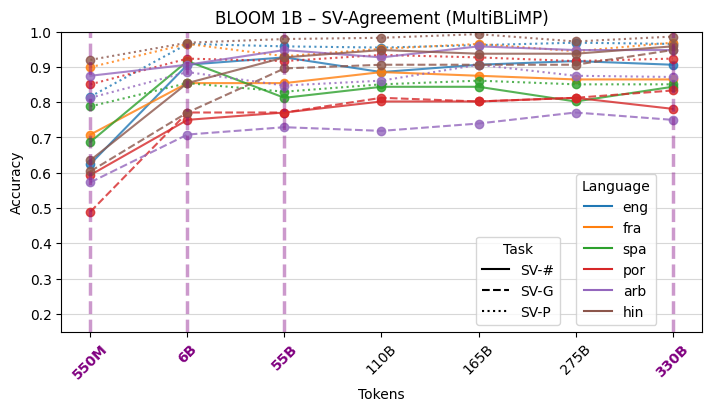

In [6]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from vis import revision2tokens_bloom

line_styles = {
    'SV-#': 'solid',
    'SV-G': 'dashed',
    'SV-P': 'dotted'
}

def plot_bloom_sv_agreement(full_dict,
                            revision2tokens_bloom,
                            save_path=None,
                            figsize=(7,4),
                            cmap_name='tab10',
                            highlight_indices=[0, 1, 2, 6]):
    """
    full_dict:      { lang: { task: { 'global_stepN': score, ... }, ... }, ... }
    revision2tokens_bloom:  function mapping 'global_stepN' → token count
    save_path:      if not None, path (e.g. 'out.pdf') to write the figure
    figsize:        (width, height) in inches
    """
    # 1) prep
    colors = plt.cm.get_cmap(cmap_name)
    languages = list(full_dict.keys())
    lang_colors = {lang: colors(i % colors.N) for i, lang in enumerate(languages)}
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

    # 2) plot each language‐task curve
    for lang, tasks in full_dict.items():
        for task, results in tasks.items():
            if results is None:
                continue
            # sort by numeric step
            steps = sorted(results.items(),
                           key=lambda kv: int(kv[0].replace('global_step','')))
            x = [revision2tokens_bloom(k) for k, _ in steps]
            y = [v for _, v in steps]
            label = f"{lang}-{task}"
            ax.plot(
                x, y, label=label,
                color=lang_colors[lang],
                linestyle=line_styles.get(task, 'solid'),
                marker='o', alpha=0.8
            )

    # 3) axis labels / title / grid / legend / color
    # axis labels
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Accuracy')
    ax.set_title('BLOOM 1B – SV-Agreement (MultiBLiMP)')
    ax.set_ylim(0.15, 1.0)

    # grid
    ax.grid(True, axis='y', alpha=0.5)

    # custom legends
    language_handles = [
        mlines.Line2D([], [], color=lang_colors[lang],
                      linestyle='solid', label=lang)
        for lang in languages
    ]
    task_handles = [
        mlines.Line2D([], [], color='black',
                      linestyle=style, label=task)
        for task, style in line_styles.items()
    ]

    # place first (language) legend
    first_legend = ax.legend(handles=language_handles,
                             title='Language',
                             loc='lower right',
                             bbox_to_anchor=(0.94, 0))
    ax.add_artist(first_legend)

    # place second (task) legend
    ax.legend(handles=task_handles,
              title='Task',
              loc='lower right',
              bbox_to_anchor=(0.79, 0))
    ax.tick_params(axis='x', rotation=45)
    
    # color choice
    hl_color = "purple"

    # 4) draw the vertical lines
    for xi in highlight_indices:
        ax.axvline(x=xi, color=hl_color, linestyle="--", linewidth=2.5, alpha=0.4)

    # 5) recolor the matching tick‐labels
    for i, lbl in enumerate(ax.get_xticklabels()):
        if i in highlight_indices:
            lbl.set_color(hl_color)
            lbl.set_fontweight("bold")

    # 6) legend/grid/tight_layout
    # fig.tight_layout(pad=0)
    
    # 7) save the PDF (or show interactively)
    if save_path:
        fig.savefig(
            save_path,
            format='pdf',
            bbox_inches='tight',
            pad_inches=0
        )
    
    plt.show()
    plt.close(fig)


filename = f"workspace/results/lm_eval_harness_res/bloom1b_multiblimp_performance.json"
loaded_full_dict = None
with open(filename, 'r') as read_file:
    loaded_full_dict = json.load(read_file)
    
plot_bloom_sv_agreement(loaded_full_dict,
                        revision2tokens_bloom,
                        save_path="figs/bloom_multiblimp_acc.pdf")

# Activation Cosine Similarity Plots

In [7]:
def prepare_activ_dataset(dataset_name, model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    
    dataset = load_task_dataset(dataset_name, tokenizer=tokenizer)
    texts = [inp + tgt for inp, tgt in zip(dataset["train"]["clean_prefix"], dataset["train"]["clean_answer"])]
    num_examples = len(texts)
    n_batches = math.floor(num_examples / batch_size)
    batches = [
        texts[batch * batch_size : (batch + 1) * batch_size]
        for batch in range(n_batches)
    ]
    if len(batches) != 0:
        print(batches[0])
    
    return batches

def cosine_sim(A: torch.Tensor, B: torch.Tensor, dim=-1):
    """
    A, B: tensors of shape [..., D]
    Returns: cosine similarity per sample along dim.
    """
    return F.cosine_similarity(A, B, dim=dim)

def pearson_corr(A: torch.Tensor, B: torch.Tensor, dim=-1, eps=1e-8):
    """
    Compute Pearson correlation along the last dim.
    """
    A_mean = A.mean(dim=dim, keepdim=True)
    B_mean = B.mean(dim=dim, keepdim=True)
    A_c = A - A_mean
    B_c = B - B_mean
    num = (A_c * B_c).sum(dim=dim)
    den = torch.sqrt((A_c**2).sum(dim=dim) * (B_c**2).sum(dim=dim)).clamp(min=eps)
    return num / den

def get_activations(model, submodule, tokens):
    """
    Run inputs through model and capture the activations at the given submodule.
    """
    with model.trace(tokens, **tracer_kwargs):
        hidden_states = submodule.output.save()
        curr_input = model.inputs.save()
        submodule.output.stop()
        
    attn_mask = curr_input.value[1]["attention_mask"]
    hidden_states = hidden_states.value
    if isinstance(hidden_states, tuple):
        hidden_states = hidden_states[0]
    hidden_states = hidden_states[attn_mask != 0]
    return hidden_states

def get_cached_batch_acts(
    model_name, 
    rev, 
    model, 
    submodule, 
    batch_inputs, 
    layer_num,
    batch_idx, 
    cache_dir="workspace/act_cache"
):
    os.makedirs(cache_dir, exist_ok=True)
    fname = f"{model_name.replace('/','_')}_{rev}_layer{layer_num}_batch{batch_idx}.pt"
    path  = os.path.join(cache_dir, fname)

    if os.path.exists(path):
        return torch.load(path)

    # get_activations returns [batch, seq_len, hidden_dim]
    acts = get_activations(model, submodule, batch_inputs)
    torch.save(acts, path)
    return acts

def compare_checkpoints(model_name, revs, batched_inputs, layer_num, skip_model_loading=False):
    results = {}  # (rev_a, rev_b) -> list of (cos, corr) per batch
    all_combo = list(combinations(revs, 2))
    print("Total number of combinations: ", len(all_combo))
    
    for a, b in tqdm(all_combo, desc="Combos"):
        key = (a, b)
        results[key] = []
        
        model_list = [None, None]
        submodule1 = None
        submodule2 = None
        if not skip_model_loading:
            model_list = load_revision_nnsight(
                model_name=model_name,
                revision_list=[a, b],
                device="cuda:0",
                seed=42
            )
            submodule1 = get_submodule_at_layernum(
                model=model_list[0],
                model_name=model_name, 
                layer_num=layer_num
            )
            submodule2 = get_submodule_at_layernum(
                model=model_list[1],
                model_name=model_name, 
                layer_num=layer_num
            )


        # for idx, batch in enumerate(batched_inputs):
        for idx, batch in tqdm(enumerate(batches)):
            A = get_cached_batch_acts(model_name, a, model_list[0], submodule1, batch, layer_num, idx)
            B = get_cached_batch_acts(model_name, b, model_list[1], submodule2, batch, layer_num, idx)

            # each is [batch, dim]
            cos_batch  = cosine_sim(A, B, dim=1).mean().item()
            corr_batch = pearson_corr(A, B, dim=1).mean().item()
            results[key].append((cos_batch, corr_batch))

            # free memory
            del A, B

    # aggregate
    summary = {}
    for key, vals in results.items():
        cossims, corrs = zip(*vals)
        summary[key] = {
            "avg_cosine":  sum(cossims) / len(cossims),
            "avg_pearson": sum(corrs) / len(corrs),
        }
        
    filename = f"workspace/act_cache/summary_{model_name.replace('/','_')}_layer{layer_num}.json"
    new_summary = {str(k): v for k, v in summary.items()}
    json_dict = json.dumps(new_summary,  ensure_ascii=False, indent=4) 
    f = open(filename, "w")
    f.write(json_dict)
    f.close()
            
    return summary

In [8]:
def dict_to_df(d, metric_key, order, model_name):
    """
    Convert the nested dict to a symmetric DataFrame for `metric_key`
    following the user-provided axis order.
    """
    if "pythia" in model_name:
        rev2tok = revision2tokens_pythia
    elif "olmo" in model_name:
        rev2tok = revision2tokens_olmo
    elif "bloom" in model_name:
        rev2tok = revision2tokens_bloom
    else:
        raise ValueError(f"Unknown model: {model_name!r}")

    ordered_steps = [rev2tok(s) for s in order]
    df = pd.DataFrame(np.nan, index=ordered_steps, columns=ordered_steps)
    for (row_key, col_key), metrics in d.items():
        if row_key in order and col_key in order:
            val = metrics.get(metric_key, np.nan)
            i = rev2tok(row_key)
            j = rev2tok(col_key)
            df.loc[i, j] = np.nan
            df.loc[j, i] = val
    return df

def plot_metric_heatmap(d, metric_key, order,
                        title=None, model_name=None,
                        figsize=(7,4), save_path=None, show_cbar=True):
    """
    Draw a confusion-matrix-style heatmap for the chosen metric,
    with tight, reproducible margins and optional PDF export.
    """
    df = dict_to_df(d, metric_key, order, model_name)

    # 1) create figure+axes with constrained layout
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

    # 2) plot the heatmap
    im = ax.imshow(df.values, aspect='auto', vmin=0.0, vmax=1.0)

    # 3) colorbar
    if show_cbar:
        cbar = fig.colorbar(im, ax=ax)

    # 4) ticks & labels
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, ha='right')
    # rotate x-labels:
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Tokens")
    
    yticks = np.arange(len(df.index))
    ytick_labels = [label if i % 2 == 0 else "" for i, label in enumerate(df.index)]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)


    # 5) title
    ax.set_title(title or f"Heatmap of {metric_key}")

    # 6) either save or show
    if save_path:
        fig.savefig(save_path,
                    format='pdf',
                    bbox_inches='tight',
                    pad_inches=0)
    plt.show()
    plt.close(fig)

### Pythia

31


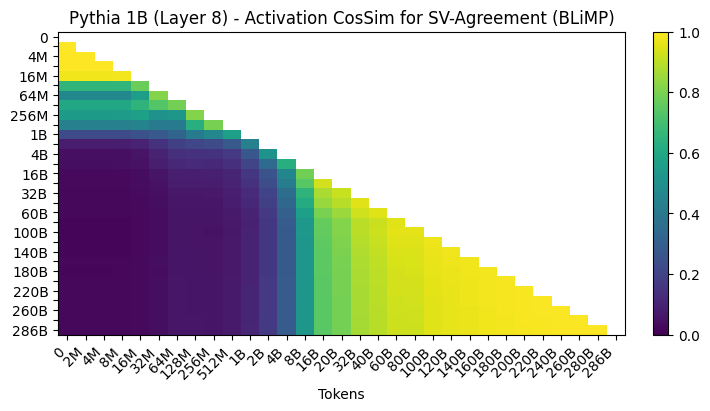

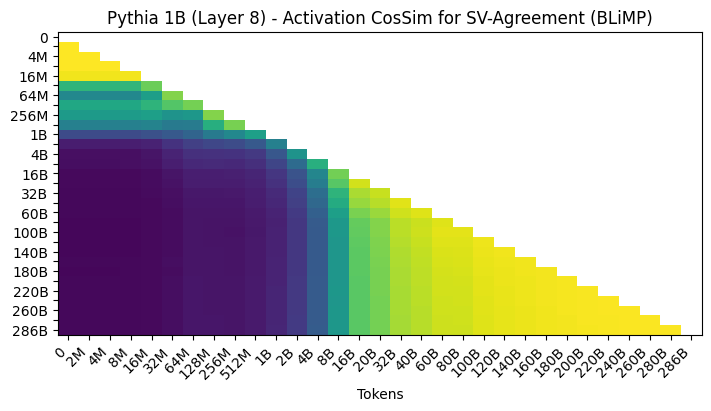

In [9]:
# Set following variables:
layer_num = 8
batch_size = 32
model_name = "EleutherAI/pythia-1b"
dataset_name = "subjectverb"
revision_list = prepare_pythia_revision_list()

filename = f"workspace/act_cache/summary_{model_name.replace('/','_')}_layer{layer_num}.json"
pythia_summary = None
with open(filename, 'r') as read_file:
    pythia_summary = json.load(read_file)

pythia_summary = {literal_eval(k): v for k, v in pythia_summary.items()}

plot_metric_heatmap(pythia_summary, 'avg_cosine', revision_list, "Pythia 1B (Layer 8) - Activation CosSim for SV-Agreement (BLiMP)", model_name="pythia", save_path="figs/pythia_blimp_activ.pdf")
plot_metric_heatmap(pythia_summary, 'avg_cosine', revision_list, "Pythia 1B (Layer 8) - Activation CosSim for SV-Agreement (BLiMP)", model_name="pythia", save_path="figs/pythia_blimp_activ_nocbar.pdf", show_cbar=False)

### OLMo

35


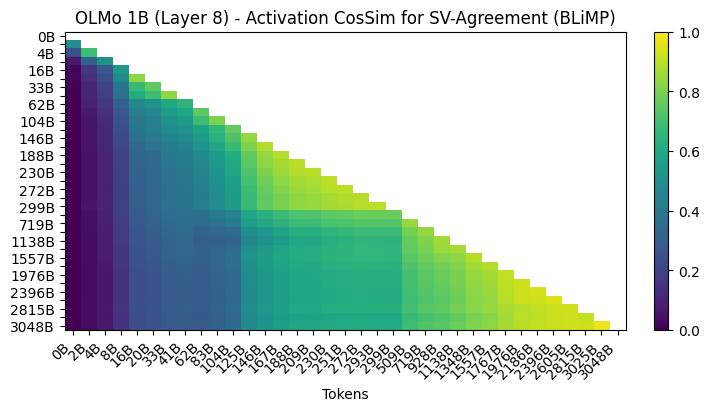

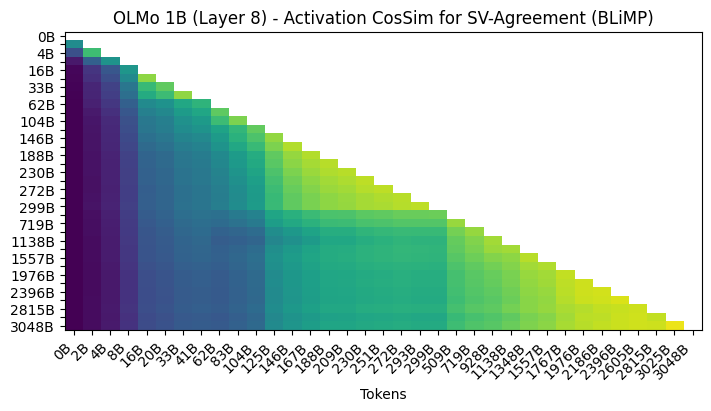

In [10]:
layer_num = 8
batch_size = 32
model_name = "allenai/OLMo-1B-0724-hf"
dataset_name = "subjectverb"
revision_list = prepare_olmo_revision_list()

filename = f"workspace/act_cache/summary_{model_name.replace('/','_')}_layer{layer_num}.json"
olmo_summary = None
with open(filename, 'r') as read_file:
    olmo_summary = json.load(read_file)

olmo_summary = {literal_eval(k): v for k, v in olmo_summary.items()}
plot_metric_heatmap(olmo_summary, 'avg_cosine', revision_list, "OLMo 1B (Layer 8) - Activation CosSim for SV-Agreement (BLiMP)", model_name="olmo", save_path="figs/olmo_blimp_activ.pdf", show_cbar=True)
plot_metric_heatmap(olmo_summary, 'avg_cosine', revision_list, "OLMo 1B (Layer 8) - Activation CosSim for SV-Agreement (BLiMP)", model_name="olmo", save_path="figs/olmo_blimp_activ_nocbar.pdf", show_cbar=False)

7


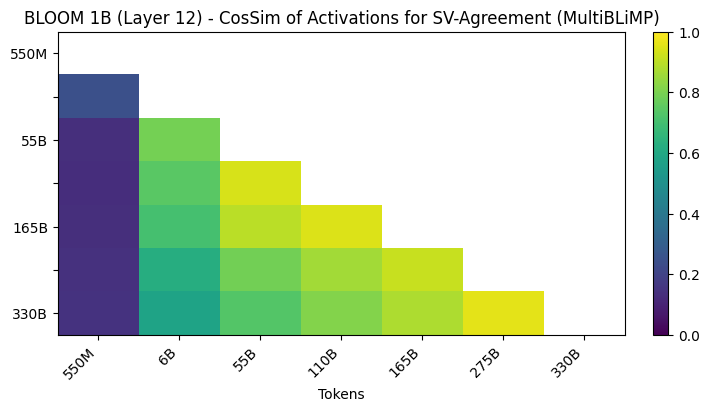

In [11]:
layer_num = 12
batch_size = 32
model_name = "bigscience/bloom-1b1-intermediate"
dataset_name = "multiblimp_all_all"
revision_list = prepare_bloom_revision_list()

filename = f"workspace/act_cache/summary_{model_name.replace('/','_')}_layer{layer_num}.json"
bloom_summary = None
with open(filename, 'r') as read_file:
    bloom_summary = json.load(read_file)
bloom_summary = {literal_eval(k): v for k, v in bloom_summary.items()}

plot_metric_heatmap(bloom_summary, 'avg_cosine', revision_list, "BLOOM 1B (Layer 12) - CosSim of Activations for SV-Agreement (MultiBLiMP)", "bloom", save_path="figs/bloom_multiblimp_activ.pdf", show_cbar=True)